# Comparing sea ice extent from observations and Earth System Models
Sea ice extent was calculated following [Hobbs et al 2016](10.1016/j.gloplacha.2016.06.008). They added the area of all ocean grid cells that had a sea ice concentration of 15\% or higher.

Sea ice concentration data is the same used in [sea ice concentration comparisons](https://github.com/Fish-MIP/SOMEME/blob/main/scripts/Comparing_sic_data_obs_models.ipynb).

## Loading relevant libraries

In [1]:
#Packages for file management
import os
from glob import glob

#Data wrangling
import pandas as pd
import numpy as np
import xarray as xr
from itertools import cycle
import string
import re

#Packages for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean as cm
import matplotlib.gridspec as gridspec

## Setting working directory

In [2]:
os.chdir('/g/data/jk72/la6889/FishMIP/SOMEME/')

## Loading sea ice concentration (SIC) datasets

In [3]:
#Loading GFDL data
gfdl_sic = xr.open_dataarray('data/gfdl-mom6-cobalt2_obsclim_siconc_15arcmin_global_monthly_1961_2010.nc')
gfdl_sic = gfdl_sic.sel(lat = slice(-30, -90))

#Loading GFDL area of grid cells
gfdl_area = xr.open_dataarray('data/gfdl-mom6-cobalt2_areacello_15arcmin_global_fixed.nc')
#Transform from m2 to km2
gfdl_area = gfdl_area.sel(lat = slice(-30, -90))*1e-6

#Calculate sea ice extent
gfdl_sie = xr.where(gfdl_sic >= 15, gfdl_area, np.nan)
gfdl_sie = gfdl_sie.sum(('lat', 'lon'))

0.3.0


In [4]:
gfdl_sie_month_mean = gfdl_sie.groupby('time.month').mean().to_pandas()
gfdl_sie_month_mean = gfdl_sie_month_mean.reset_index().rename(columns = {0: 'mean'})
gfdl_sie_month_std = gfdl_sie.groupby('time.month').std().to_pandas()
gfdl_sie_month_std = gfdl_sie_month_std.reset_index().rename(columns = {0: 'std'})

<Axes: xlabel='month'>

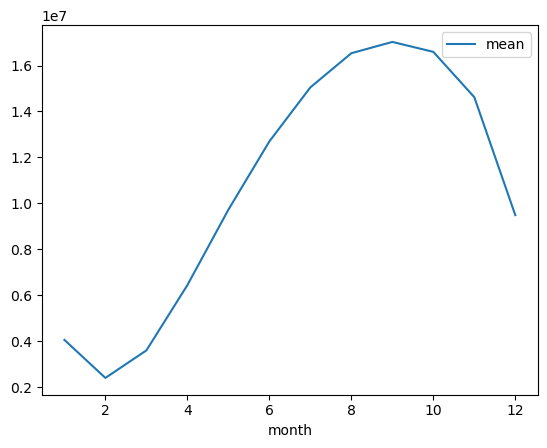

In [5]:
gfdl_sie_month_mean.plot(x = 'month',y = 'mean')

We will load climatological means calculated from each CMIP6 model included in our ensemble.

In [6]:
#Getting list of all models available in folder
cmip_files = glob('data/CMIP6/climatologies/*monthly*')

#Initiliasing empty list to store results
cmip_ds = []

#Loop through each file
for f in cmip_files:
    #Get name of model to add as dimension
    model = re.findall('SImon_(.*)_hist', os.path.basename(f))
    #load data array
    da = xr.open_dataarray(f)
    #If "type" dimension exists remove it
    if 'type' in da.coords:
        da = da.drop_vars('type')
    #Adding model name and store in empty list
    cmip_ds.append(da.expand_dims({'mod': model}))

#Create a single data array with all CMIP6 models
cmip_ds = xr.concat(cmip_ds, dim = 'mod')

#Save regional ensemble data
cmip_ds.to_netcdf('data/CMIP6/climatologies/clim_months_all_models.nc')

## Loading area of grid cells

In [ ]:
#Loading observations
nsidc_ds = xr.open_dataarray('data/SIC_NASA/sic_nasa_goddard_60arcmin_1982-2010.nc')
